In [60]:
import geopandas as gpd
import itertools
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import shapely.geometry
from datetime import datetime
from itertools import combinations
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import warnings
import ptitprince as pt

warnings.filterwarnings("ignore")


In [61]:
def read_raster(filepath):
    with rasterio.open(filepath) as src:
        return src.read(1), src.transform, src.meta


In [62]:
def clip_raster_to_aoi(filepath, bbox_geojson):
    bbox_geom = gpd.GeoDataFrame.from_features(
        [{"type": "Feature", "properties": {}, "geometry": bbox_geojson}],
        crs="EPSG:4326",
    )
    with rasterio.open(filepath) as src:
        src_crs = src.crs if src.crs else "EPSG:4326"
        bbox_geom = bbox_geom.to_crs(crs=src_crs)
        intersection = bbox_geom.unary_union.intersection(
            shapely.geometry.box(*src.bounds)
        )
        if not intersection.is_empty:
            out_image, out_transform = mask(src, shapes=[intersection], crop=True)
            out_meta = src.meta.copy()
            out_meta.update(
                {
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "nodata": np.nan,
                }
            )
            return out_image.squeeze(), out_transform, out_meta


In [63]:
def align_raster(
    source_array,
    source_transform,
    source_meta,
    target_transform,
    target_crs,
    template_shape,
):
    aligned_array = np.empty(template_shape)
    reproject(
        source=source_array,
        destination=aligned_array,
        src_transform=source_transform,
        src_crs=source_meta["crs"],
        dst_transform=target_transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest,
    )
    return aligned_array


In [64]:
def preprocess_raster(array):
    array[(array < -10) | (array > 10)] = np.nan
    return array


In [65]:
def calculate_difference(array1, array2, date1, date2):
    valid_mask = np.isfinite(array1) & np.isfinite(array2)
    difference = array2 - array1
    difference[~valid_mask] = np.nan
    dt1 = datetime.strptime(date1, "%m/%d/%y")
    dt2 = datetime.strptime(date2, "%m/%d/%y")
    time_diff_years = (dt2 - dt1).days / 365.25
    print(f"Time difference: {np.round(time_diff_years, 1)} years")
    rate_of_change = difference / time_diff_years
    return rate_of_change


In [66]:
def create_dataframe(z, dz):
    return pd.DataFrame({"Raster Values": z.flatten(), "dz/dt": dz.flatten()})


def initialize_joint_grid(df):
    g = sns.JointGrid(
        data=df,
        x="Raster Values",
        y="dz/dt",
        marginal_ticks=True,
        space=0.5,
        height=8,
        ratio=4,
    )
    g.fig.set_facecolor("white")
    return g


def plot_kde_with_colorbar(g):
    cbar_ax = g.fig.add_axes([0.63, 0.15, 0.05, 0.2])  # x, y, width, height
    g.plot_joint(
        sns.kdeplot,
        fill=True,
        thresh=0.05,
        levels=100,
        cmap="coolwarm",
        cbar=True,
        cbar_ax=cbar_ax,
    )
    cbar_ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.3f}"))
    return g


def plot_marginal_histograms(g):
    g.plot_marginals(
        sns.histplot,
        alpha=0.5,
        stat="probability",
        kde=True,
        bins=300,
        color="#03012d",
        element="step",
    )
    return g


def set_axis_labels_and_title(g, names):
    g.ax_marg_x.set_ylabel("Probability")
    g.ax_marg_y.set_ylabel("Probability")

    ylabel = "dz/dt (m/yr)"
    xlabel = f"z ({names[0]}) (m)"

    g.set_axis_labels(f"{xlabel}", f"{ylabel}")
    g.ax_joint.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, _: "{:.1f}".format(x))
    )
    g.ax_joint.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda y, _: "{:.2f}".format(y))
    )

    g.fig.suptitle(f"Change in {names[0]} vs {names[1]} Over Time", fontsize=16)
    g.fig.subplots_adjust(top=0.95)  # Adjust to make space for the title


def save_figure(names):
    plt.savefig(
        f"Results/Plots/2d_histogram ({names[0]} - {names[1]}).svg", format="svg"
    )


# def plot_2d_histogram(dz, z, names):
#     df = create_dataframe(z, dz)
#     g = initialize_joint_grid(df)
#     g = plot_kde_with_colorbar(g)
#     g = plot_marginal_histograms(g)
#     set_axis_labels_and_title(g, names)
#     save_figure(names)


def plot_2d_histogram(dz, z, names):
    df = create_dataframe(z, dz)
    accretion_df = df[df["dz/dt"] > 0]
    erosion_df = df[df["dz/dt"] < 0]

    plt.figure(figsize=(10, 8))

    sns.kdeplot(data=df, x="dz/dt", color="red", label="Combined", linewidth=1.5)
    sns.kdeplot(data=accretion_df, x="dz/dt", color="green", label="Accretion", linewidth=1.5)
    sns.kdeplot(data=erosion_df, x="dz/dt", color="blue", label="Erosion", linewidth=1.5)

    plt.xlabel('dz/dt (m/yr)')
    plt.ylabel('Density')
    plt.title('Density of dz/dt: Combined, Accretion, and Erosion')
    plt.legend()
    plt.show()
    save_figure(names)


In [67]:
# import ptitprince as pt
# import matplotlib.pyplot as plt


# def plot_2d_histogram(dz, z, names):
#     df = create_dataframe(z, dz)
#     accretion_df = df[df["dz/dt"] > 0]
#     erosion_df = df[df["dz/dt"] < 0]

#     fig, ax = plt.subplots(figsize=(10, 8))

#     # Combine dataframes with a label for coloring
#     df["Type"] = "Combined"
#     accretion_df["Type"] = "Accretion"
#     erosion_df["Type"] = "Erosion"
#     combined_df = pd.concat([df, accretion_df, erosion_df])

#     pt.RainCloud(
#         x="Type",
#         y="dz/dt",
#         data=combined_df,
#         palette=["red", "green", "blue"],
#         bw=0.2,
#         width_viol=0.6,
#         ax=ax,
#         orient="h",
#         point_size=0.01,
#         box_showfliers=True,
#         box_flierprops={"markerfacecolor": "r", "marker": "o", "markersize": 3},
#     )

#     plt.xlabel("dz/dt")
#     plt.title("Raincloud plot of dz/dt: Combined, Accretion, and Erosion")
#     plt.tight_layout()
#     plt.show()


In [68]:
def load_and_preprocess_rasters(raster_pair, bbox_geojson):
    rasters = []
    names = []
    dates = []
    first_array_shape = None
    first_transform = None
    first_meta = None

    for path_info_tuple in raster_pair:
        path, (name, date) = path_info_tuple
        path = f"Data/{path}"
        if first_array_shape is None:
            array, transform, meta = clip_raster_to_aoi(path, bbox_geojson)
            first_array_shape = array.shape
            first_transform = transform
            first_meta = meta
        else:
            array, transform, meta = clip_raster_to_aoi(path, bbox_geojson)
            array = align_raster(
                array,
                transform,
                meta,
                first_transform,
                first_meta["crs"],
                first_array_shape,
            )
        array = preprocess_raster(array)
        rasters.append(array)
        names.append(name)
        dates.append(date)
    return rasters, names, dates


def calculate_differences_between_rasters(rasters, dates):
    difference = calculate_difference(rasters[0], rasters[1], dates[0], dates[1])
    return difference


def plot_results_and_generate_output(rasters, names, difference):
    plot_2d_histogram(difference, rasters[0], names)
    return None


def main(rasters_combination, bbox_geojson):
    for raster_pair in rasters_combination:
        rasters, names, dates = load_and_preprocess_rasters(raster_pair, bbox_geojson)
        difference = calculate_differences_between_rasters(rasters, dates)
        plot_results_and_generate_output(rasters, names, difference)


In [69]:
rasters_dict = {
    "Clipped(2001)_meter.tif": ("DEM 2001", "10/13/01"),
    "Clipped(2002)_meter.tif": ("DEM 2002", "9/18/02"),
}


In [70]:
# rasters_dict = {
#     'Clipped(2001)_meter.tif': ('DEM 2001', '10/13/01'),
#     "Clipped(2002)_meter.tif": ("DEM 2002", "9/18/02"),
#     # "Clipped(2006)_meter.tif": ("DEM 2006", "4/26/06"),
#     'Clipped(2009)_meter.tif': ('DEM 2009', '3/15/09'),
#     # 'Clipped(2016)_meter.tif': ('DEM 2016', '8/31/16'),
#     'Clipped(2018)_meter.tif': ('DEM 2018', '2/16/18'),
#     '(Clipped)2018_19_post_harvey_meter.tif': ('DEM 2018_19_post_harvey', '2/9/19')
# }


In [71]:
bbox_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [-95.514107383931105, 28.837294991608498],
            [-95.542191067157702, 28.82310160914],
            [-95.533023536824004, 28.807894014576299],
            [-95.5039012207138, 28.822751403692301],
            [-95.514107383931105, 28.837294991608498],
        ]
    ],
}


Time difference: 0.9 years


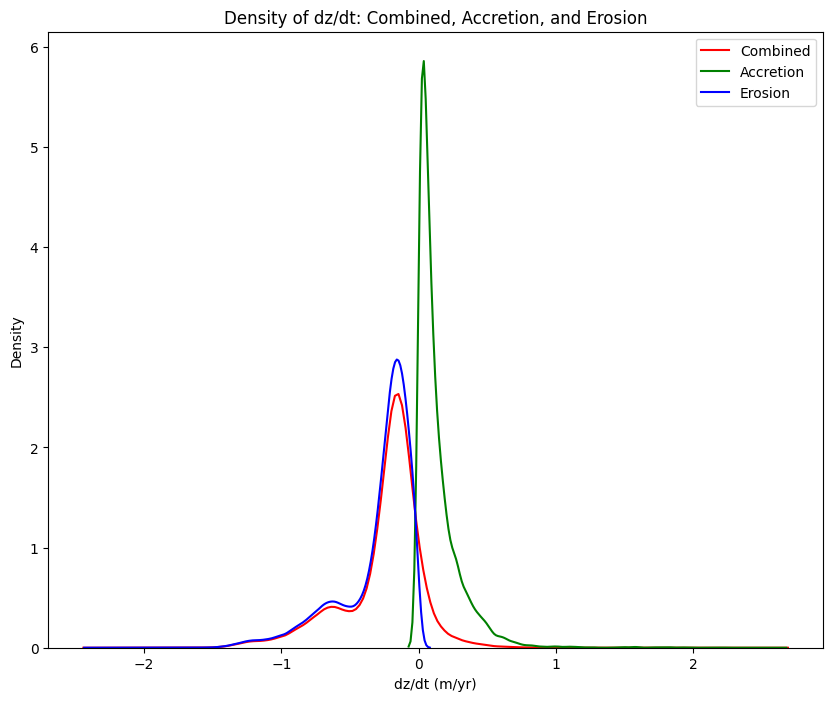

<Figure size 640x480 with 0 Axes>

In [72]:
rasters_combination = combinations(rasters_dict.items(), 2)
results = main(rasters_combination, bbox_geojson)
